In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

BOARD_SIZE = 100
LADDER_LENGTH = 10
SNAKE_LENGTH = 10
BOARD_DIM = int(np.sqrt(BOARD_SIZE)) # Dimension of the board (10x10)

In [23]:
def generate_board(num_snakes, num_ladders):
    snakes_and_ladders = {}
    snake_starts = []
    snake_ends = []
    ladder_starts = []
    ladder_ends = []
    iterations = 0

    while True:
        iterations += 1
        current_snakes_and_ladders = {}
        current_snake_starts = []
        current_snake_ends = []
        current_ladder_starts = []
        current_ladder_ends = []

        potential_ladders = random.sample(range(1, BOARD_SIZE - LADDER_LENGTH), num_ladders)
        potential_snakes = random.sample(range(SNAKE_LENGTH + 1, BOARD_SIZE), num_snakes)

        for ladder_start in potential_ladders:
            ladder_end = ladder_start + LADDER_LENGTH
            if ladder_end not in current_snakes_and_ladders and ladder_end not in current_snakes_and_ladders.values():
                current_snakes_and_ladders[ladder_start] = ladder_end
                current_ladder_starts.append(ladder_start)
                current_ladder_ends.append(ladder_end)

        for snake_start in potential_snakes:
            snake_end = snake_start - SNAKE_LENGTH
            if snake_end not in current_snakes_and_ladders and snake_end not in current_snakes_and_ladders.values():
                current_snakes_and_ladders[snake_start] = snake_end
                current_snake_starts.append(snake_start)
                current_snake_ends.append(snake_end)

        overlaps = [pos for pos in current_snakes_and_ladders if list(current_snakes_and_ladders.values()).count(pos) > 1]
        if not overlaps:
            snakes_and_ladders = current_snakes_and_ladders
            snake_starts = current_snake_starts
            snake_ends = current_snake_ends
            ladder_starts = current_ladder_starts
            ladder_ends = current_ladder_ends
            break

        # Basic overlap resolution (can be improved if needed)
        for overlap in overlaps:
            keys_with_overlap = [key for key, value in current_snakes_and_ladders.items() if value == overlap]
            for key in keys_with_overlap:
                del current_snakes_and_ladders[key]
                if key > overlap: # It was a snake
                    current_snake_starts.remove(key)
                    current_snake_ends.remove(overlap)
                else: # It was a ladder
                    current_ladder_starts.remove(key)
                    current_ladder_ends.remove(overlap)


    print(f"Board generated in {iterations} iterations.")
    return snakes_and_ladders, snake_starts, snake_ends, ladder_starts, ladder_ends


def play_game(snakes_and_ladders):
    position = 0
    moves = 0
    while position < BOARD_SIZE:
        dice_roll = random.SystemRandom().randint(1, 6)
        position += dice_roll
        moves += 1
        if position in snakes_and_ladders:
            position = snakes_and_ladders[position]
        if position > BOARD_SIZE:
            position = BOARD_SIZE
    return moves


def run_simulations(num_simulations, snakes_and_ladders):
    game_times = []
    for _ in range(num_simulations):
        game_times.append(play_game(snakes_and_ladders))
    return game_times


def draw_board(n, snake_heads, snake_tails, ladder_bottoms, ladder_tops, save_path):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)

    # Draw board grid numbers and alternating row direction
    for i in range(1, n * n + 1):
        row_index = (i - 1) // n  # Row index from 0 (bottom) to n-1 (top)
        col_index = (i - 1) % n  # Column index from 0 (left) to n-1 (right)

        # For even rows (0, 2, 4, ... from bottom), numbers are left to right
        # For odd rows (1, 3, 5, ... from bottom), numbers are right to left
        if row_index % 2 == 1: # Check if row_index is odd (for reversed numbering)
            col_index = n - 1 - col_index # Reverse column index for odd rows

        x = col_index + 0.5 # Center of the cell in x
        y = row_index + 0.5 # Center of the cell in y

        # Note: with invert_yaxis(), y=0 will be at the top, and y=n at the bottom visually.
        # But mathematically, we are still working in a standard coordinate system here, then inverting for display.

        ax.text(x, y, str(i), ha='center', va='center', fontsize=8)

    # Draw snakes
    for head, tail in zip(snake_heads, snake_tails):
        head_row = (head - 1) // n
        head_col = (head - 1) % n
        if head_row % 2 == 1:
            head_col = n - 1 - head_col
        head_x = head_col + 0.5
        head_y = head_row + 0.5

        tail_row = (tail - 1) // n
        tail_col = (tail - 1) % n
        if tail_row % 2 == 1:
            tail_col = n - 1 - tail_col
        tail_x = tail_col + 0.5
        tail_y = tail_row + 0.5

        ax.plot([head_x, tail_x], [head_y, tail_y], 'r', linewidth=2, marker="o", markersize=8)

    # Draw ladders - Logic is the same as snakes for coordinate calculation
    for bottom, top in zip(ladder_bottoms, ladder_tops):
        bottom_row = (bottom - 1) // n
        bottom_col = (bottom - 1) % n
        if bottom_row % 2 == 1:
            bottom_col = n - 1 - bottom_col
        bottom_x = bottom_col + 0.5
        bottom_y = bottom_row + 0.5

        top_row = (top - 1) // n
        top_col = (top - 1) % n
        if top_row % 2 == 1:
            top_col = n - 1 - top_col
        top_x = top_col + 0.5
        top_y = top_row + 0.5
        ax.plot([bottom_x, top_x], [bottom_y, top_y], 'g', linewidth=2, marker="o", markersize=8)

    ax.set_xticks(np.arange(n + 1))
    ax.set_yticks(np.arange(n + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    ax.invert_yaxis() # Keep y-axis inverted so board starts from bottom-left
    plt.title("Snakes and Ladders Board")
    plt.savefig(save_path)
    plt.close(fig)


def save_board_layout(board_num, num_snakes, num_ladders, snake_starts, snake_ends, ladder_starts, ladder_ends, output_folder="board_layouts"):
    folder_path = os.path.join(output_folder, f"snakes_{num_snakes}_ladders_{num_ladders}")
    os.makedirs(folder_path, exist_ok=True)
    file_path = os.path.join(folder_path, f"board_{board_num}.png")
    snake_heads = snake_starts
    snake_tails = snake_ends
    ladder_bottoms = ladder_starts
    ladder_tops = ladder_ends
    draw_board(BOARD_DIM, snake_heads, snake_tails, ladder_bottoms, ladder_tops, file_path) # Use BOARD_DIM here
    print(f"Board layout saved to {file_path}")


def save_game_times_to_csv(game_time_distributions, output_folder="game_data"):
    os.makedirs(output_folder, exist_ok=True)
    for config, board_data in game_time_distributions.items():
        num_snakes = config.split("_")[1]
        num_ladders = config.split("_")[3]
        for board_num, times in enumerate(board_data, 1):
            data = pd.DataFrame({'game_times': times})
            filename = os.path.join(output_folder, f"snakes_{num_snakes}_ladders_{num_ladders}_board_{board_num}.csv")
            data.to_csv(filename, index=False)
            print(f"Game times saved to {filename}")


def plot_float_ratio_box_and_whiskers(all_avg_game_times):
    # Group data by float ratios (e.g., 0.5, 1.0, 1.5, 2.0)
    ratio_groups = {}
    
    for config, data in all_avg_game_times.items():
        parts = config.split('_')
        if len(parts) >= 4:
            num_snakes = int(parts[1])
            num_ladders = int(parts[3])
            
            # Calculate the float ratio
            ratio = num_snakes / num_ladders
            ratio_key = f"{ratio:.2f}"  # Format to 2 decimal places
            
            if ratio_key not in ratio_groups:
                ratio_groups[ratio_key] = []
            
            # Add the data to the appropriate ratio group
            if data:
                ratio_groups[ratio_key].extend(data)
    
    # Sort the ratios for consistent plotting
    sorted_ratios = sorted(ratio_groups.keys(), key=lambda x: float(x))
    
    # Prepare data for plotting
    plot_data = []
    plot_labels = []
    
    for ratio in sorted_ratios:
        if ratio_groups[ratio]:
            plot_data.append(ratio_groups[ratio])
            plot_labels.append(ratio)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.boxplot(plot_data, labels=plot_labels)
    
    plt.ylabel('Average Game Duration (moves)')
    plt.xlabel('Ratio of Snakes to Ladders (Ns/Nl)')
    plt.title('Box and Whiskers Plot of Average Game Duration vs. Snake-Ladder Ratio')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_heatmap(heatmap_data):
    num_ladders_values = sorted(list(set([int(config.split('_')[3]) for config in heatmap_data.keys()])))
    num_snakes_values = sorted(list(set([int(config.split('_')[1]) for config in heatmap_data.keys()])))
    average_durations = np.zeros((len(num_snakes_values), len(num_ladders_values)))

    for config, avg_duration in heatmap_data.items():
        snake_index = num_snakes_values.index(int(config.split('_')[1]))
        ladder_index = num_ladders_values.index(int(config.split('_')[3]))
        average_durations[snake_index, ladder_index] = avg_duration

    plt.figure(figsize=(10, 8))
    plt.imshow(average_durations, cmap='viridis', origin='lower', aspect='auto',
               extent=[min(num_ladders_values)-0.5, max(num_ladders_values)+0.5, min(num_snakes_values)-0.5, max(num_snakes_values)+0.5]) # Extent to center labels
    plt.colorbar(label='Average Game Duration (moves)')
    plt.xticks(num_ladders_values)
    plt.yticks(num_snakes_values)
    plt.xlabel('Number of Ladders')
    plt.ylabel('Number of Snakes')
    plt.title('Heatmap of Average Game Duration vs. Snakes and Ladders')

    # Annotate heatmap with average durations
    for i in range(average_durations.shape[0]):
        for j in range(average_durations.shape[1]):
            plt.text(num_ladders_values[j], num_snakes_values[i], f"{average_durations[i, j]:.2f}",
                     ha='center', va='center', color='white' if average_durations[i, j] > np.percentile(average_durations, 75) else 'black')

    plt.tight_layout()
    plt.show()


def plot_fixed_ladders_vs_snakes(fixed_ladders_data, num_ladders_fixed):
    num_snakes_values = sorted([int(config.split('_')[1]) for config in fixed_ladders_data.keys()])
    average_durations = [fixed_ladders_data[f"snakes_{n}_ladders_{num_ladders_fixed}"] for n in num_snakes_values]

    plt.figure(figsize=(10, 6))
    plt.plot(num_snakes_values, average_durations, marker='o', linestyle='-')
    plt.xlabel(f'Number of Snakes (Fixed Ladders = {num_ladders_fixed})')
    plt.ylabel('Average Game Duration (moves)')
    plt.title(f'Average Game Duration vs. Number of Snakes (Fixed Ladders = {num_ladders_fixed})')
    plt.xticks(num_snakes_values)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
# Main Execution
num_simulations = 10000
num_boards_per_config = 10
output_folder = "board_layouts"
game_data_folder = "game_data"

# 1. Generate and Store Board Layout Data
board_configurations = {} # Store board layout data for later use

for num_snakes in range(5, 11):
    for num_ladders in range(5, 11):
        config_name = f"snakes_{num_snakes}_ladders_{num_ladders}"
        board_configurations[config_name] = [] # List to hold data for each board of this config
        for board_num in range(1, num_boards_per_config + 1):
            print(f"Generating board {board_num} for {config_name}...")
            snakes_and_ladders, snake_starts, snake_ends, ladder_starts, ladder_ends = generate_board(num_snakes, num_ladders)
            board_configurations[config_name].append({ # Store layout data
                'snakes_and_ladders': snakes_and_ladders,
                'snake_starts': snake_starts,
                'snake_ends': snake_ends,
                'ladder_starts': ladder_starts,
                'ladder_ends': ladder_ends
            })

# 2. Run Simulations
all_game_time_distributions = {} # Store all game times for CSV saving
all_avg_game_times_box_plot = {} # Store avg game times for box plot
all_avg_game_times_heatmap = {} # Store avg game times for heatmap
fixed_ladders_5_avg_game_times = {} # Store avg game times for fixed ladders at 5
fixed_ladders_10_avg_game_times = {} # Store avg game times for fixed ladders at 10


for num_snakes in range(5, 11):
    for num_ladders in range(5, 11):
        config_name = f"snakes_{num_snakes}_ladders_{num_ladders}"
        all_game_time_distributions[config_name] = [] # List to hold game times for each config
        board_avg_times = [] # To store average times for each board layout

        print(f"Starting simulations for {config_name}")
        for board_num in range(1, num_boards_per_config + 1):
            print(f"Running {num_simulations} simulations for board {board_num} of {config_name}...")
            board_layout_data = board_configurations[config_name][board_num-1]['snakes_and_ladders'] # Retrieve pre-generated layout
            game_times = run_simulations(num_simulations, board_layout_data)
            all_game_time_distributions[config_name].append(game_times)
            avg_game_time = np.mean(game_times)
            board_avg_times.append(avg_game_time)
            print(f"Average game time for board {board_num}: {avg_game_time:.2f} moves")

        config_avg_game_time = np.mean(board_avg_times)
        all_avg_game_times_box_plot[config_name] = board_avg_times
        all_avg_game_times_heatmap[config_name] = config_avg_game_time
        if num_ladders == 5:
            fixed_ladders_5_avg_game_times[config_name] = config_avg_game_time
        if num_ladders == 10:
            fixed_ladders_10_avg_game_times[config_name] = config_avg_game_time


# 3. Generate and Save Board Layout Images (AFTER simulations)
for num_snakes in range(5, 11):
    for num_ladders in range(5, 11):
        config_name = f"snakes_{num_snakes}_ladders_{num_ladders}"
        for board_num in range(1, num_boards_per_config + 1):
            layout_data = board_configurations[config_name][board_num-1]
            save_board_layout(board_num, num_snakes, num_ladders,
                              layout_data['snake_starts'], layout_data['snake_ends'],
                              layout_data['ladder_starts'], layout_data['ladder_ends'],
                              output_folder)


Generating board 1 for snakes_5_ladders_5...
Board generated in 1 iterations.
Generating board 2 for snakes_5_ladders_5...
Board generated in 1 iterations.
Generating board 3 for snakes_5_ladders_5...
Board generated in 1 iterations.
Generating board 4 for snakes_5_ladders_5...
Board generated in 1 iterations.
Generating board 5 for snakes_5_ladders_5...
Board generated in 1 iterations.
Generating board 6 for snakes_5_ladders_5...
Board generated in 1 iterations.
Generating board 7 for snakes_5_ladders_5...
Board generated in 1 iterations.
Generating board 8 for snakes_5_ladders_5...
Board generated in 1 iterations.
Generating board 9 for snakes_5_ladders_5...
Board generated in 1 iterations.
Generating board 10 for snakes_5_ladders_5...
Board generated in 1 iterations.
Generating board 1 for snakes_5_ladders_6...
Board generated in 1 iterations.
Generating board 2 for snakes_5_ladders_6...
Board generated in 1 iterations.
Generating board 3 for snakes_5_ladders_6...
Board generated in

Game times saved to game_data/snakes_5_ladders_5_board_1.csv
Game times saved to game_data/snakes_5_ladders_5_board_2.csv
Game times saved to game_data/snakes_5_ladders_5_board_3.csv
Game times saved to game_data/snakes_5_ladders_5_board_4.csv
Game times saved to game_data/snakes_5_ladders_5_board_5.csv
Game times saved to game_data/snakes_5_ladders_5_board_6.csv
Game times saved to game_data/snakes_5_ladders_5_board_7.csv
Game times saved to game_data/snakes_5_ladders_5_board_8.csv
Game times saved to game_data/snakes_5_ladders_5_board_9.csv
Game times saved to game_data/snakes_5_ladders_5_board_10.csv
Game times saved to game_data/snakes_5_ladders_6_board_1.csv
Game times saved to game_data/snakes_5_ladders_6_board_2.csv
Game times saved to game_data/snakes_5_ladders_6_board_3.csv
Game times saved to game_data/snakes_5_ladders_6_board_4.csv
Game times saved to game_data/snakes_5_ladders_6_board_5.csv
Game times saved to game_data/snakes_5_ladders_6_board_6.csv
Game times saved to gam

/tmp/ipykernel_6384/1520385004.py:209: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=plot_labels)


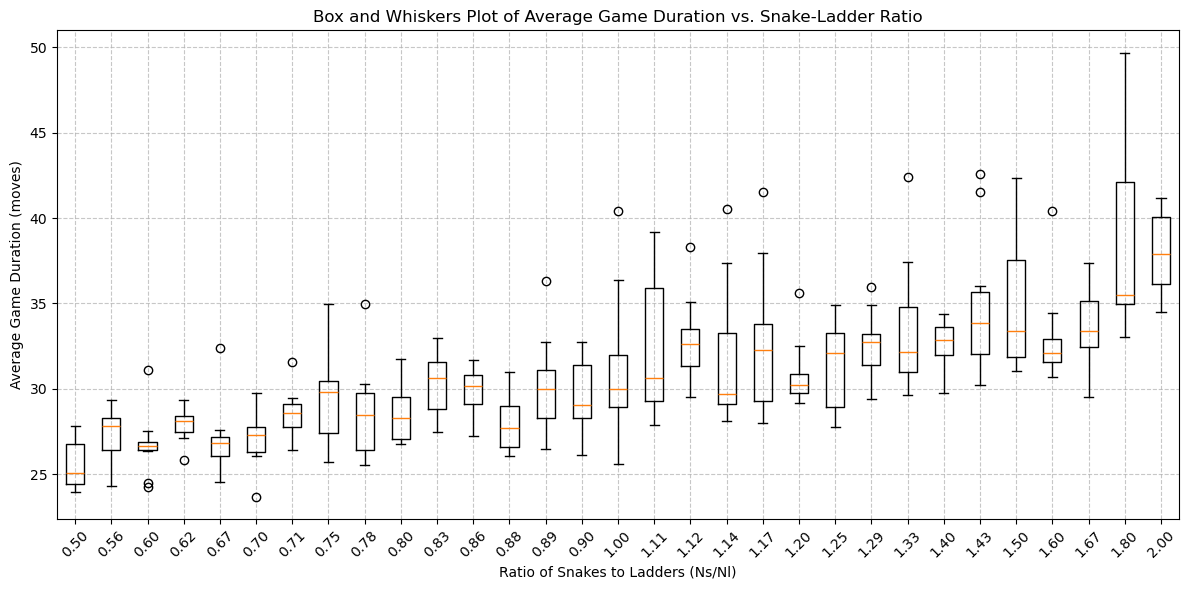

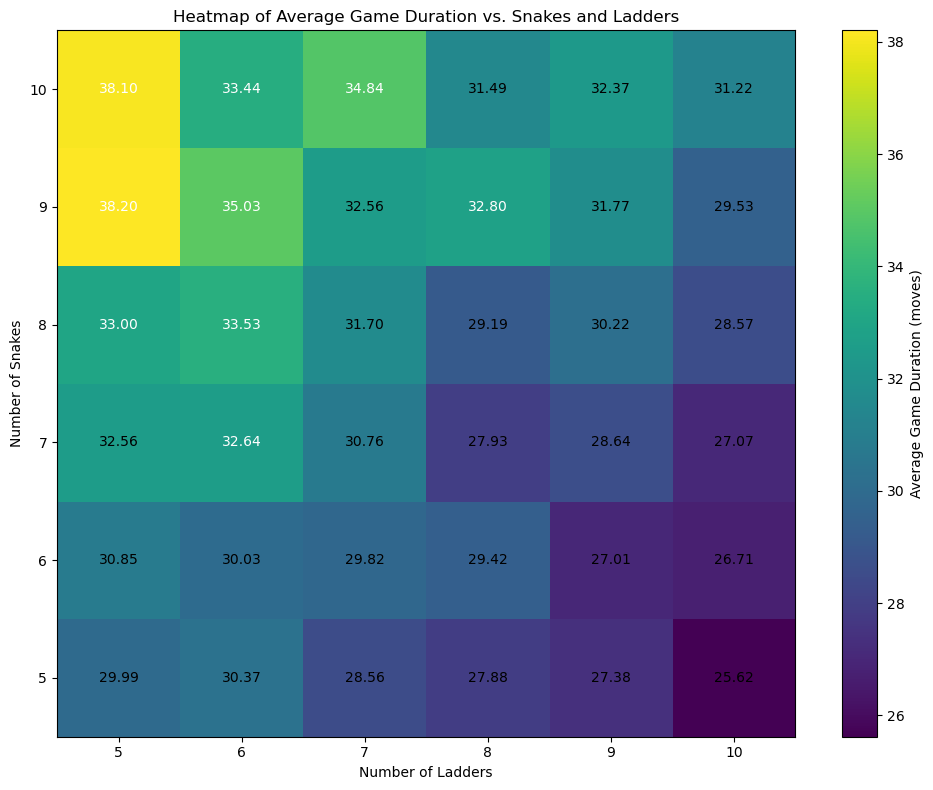

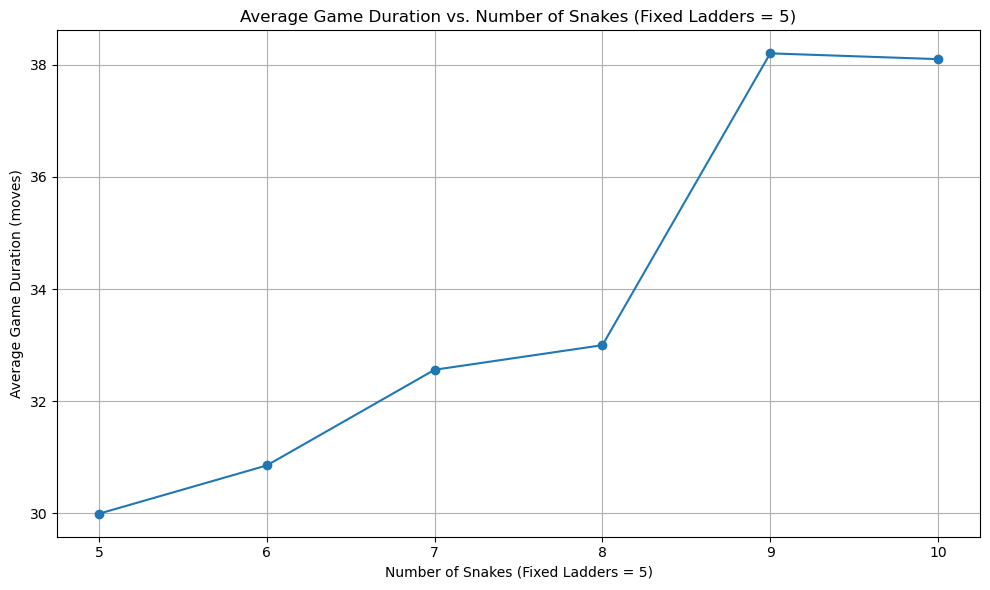

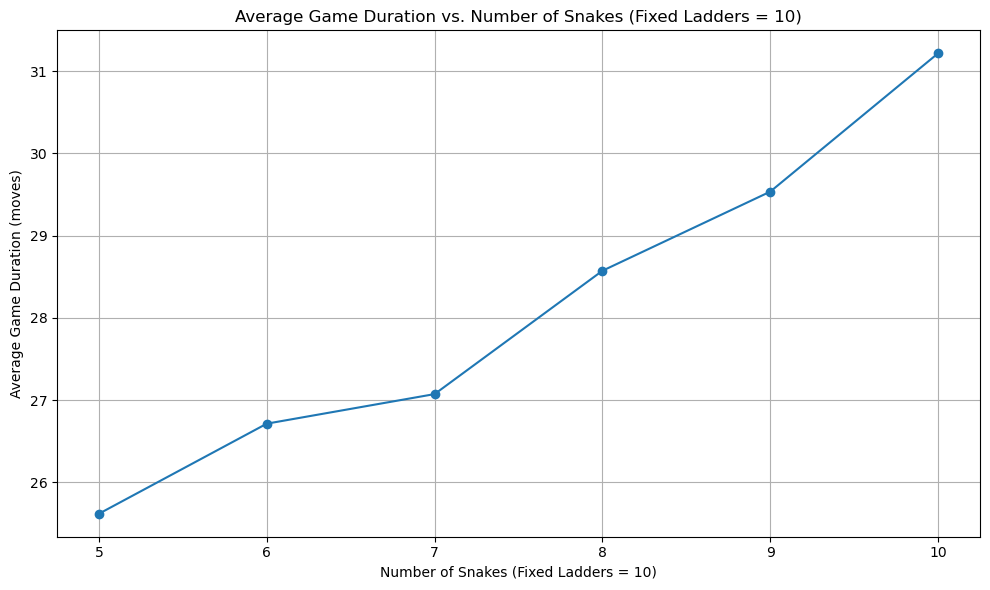

Simulation complete. Board layouts, game data, and plots generated.


In [24]:
# 4. Save all game times to CSV files
save_game_times_to_csv(all_game_time_distributions, game_data_folder)

# 5. Generate Plots
plot_float_ratio_box_and_whiskers(all_avg_game_times_box_plot)
plot_heatmap(all_avg_game_times_heatmap)
plot_fixed_ladders_vs_snakes(fixed_ladders_5_avg_game_times, num_ladders_fixed=5) # Plot for ladders fixed at 5
plot_fixed_ladders_vs_snakes(fixed_ladders_10_avg_game_times, num_ladders_fixed=10) # Plot for ladders fixed at 10
print("Simulation complete. Board layouts, game data, and plots generated.")